# Estimation of tree height using GEDI dataset - Random Forest prediction


Find a relationship between tree height and enviromental predictors to be able to predict out side the GEDI observation.  
The model, in its simplest form, looks like the following:  

```
y ~ f ( a*x1 + b*x2 + c*x3 + …)  + ε,  

```
    
where y is a response variable, the x's are predictor variables, and ε is the associated error.

**There are many different types of models**

* Parametric models – make assumptions about the underlying distribution of the data.
    * Maximum likelihood classification
    * Discriminant analysis
    * General linear models (ex. linear regression)


* Nonparametric models – make no assumptions about the underlying data distributions.
    * Generalized additive models
    * Support Vector Machine
    * Artificial neural networks
    * Random Forest

## Random forest

Random forest is a Supervised Machine Learning Algorithm that is used widely in **Classification** (containing categorical variables) and **Regression** (response continuous variables) problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.  

One of the most important features of the Random Forest Algorithm is that it can handle continuous and categorical variables predictors without any assamption on their data distribution, dimension, and even if the predictors are autocorrelated.

**Bagging**  
Bagging, also known as Bootstrap Aggregation is the ensemble technique used by random forest. Choosesing a random sample from the data set it is creating a tree. Each tree is generated from the samples (Bootstrap Samples) provided by the Original Data with replacement known as row sampling. This step of row sampling with replacement is called bootstrap.
Each is trained independently which generates results. The final output is based on majority voting after combining the results of all models. This step which involves combining all the results and generating output based on majority voting is known as tree aggregation.


**Steps involved in random forest algorithm:**  

* Step 1: In Random forest n number of random records are taken from the data set having k number of records.  

* Step 2: Individual decision trees are constructed for each sample.  

* Step 3: Each decision tree will generate an output.  
* Step 4: Final output is considered based on Majority Voting or Averaging for Classification and regression respectively.  
 
(source https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/)

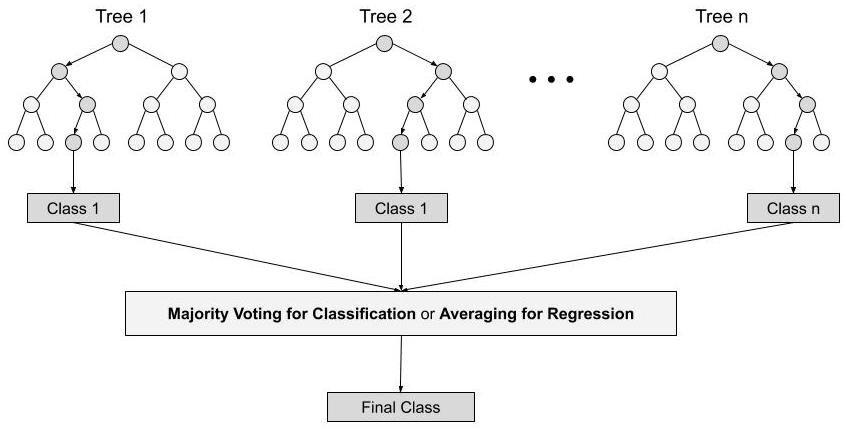

In [4]:
from IPython.display import Image
Image("../images/Random_Forest.jpg" , width = 700, height = 700)

**Random Forest exercise**   
In this exercise we will use Random Forest Regression algorithm with the [sklearn](https://scikit-learn.org/stable/) python package to estimage the tree height. In last step, we are going to use the [Pyspatialml](https://pyspatialml.readthedocs.io/en/latest/index.html) for the spatial prediction on the raster files described in tif

    pip install Pyspatialml


**Import library**

In [1]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import *
from rasterio.plot import show
from pyspatialml import Raster
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6.5)

## Import raw data, extracted predictors and show the data distribution

In [2]:
predictors = pd.read_csv("tree_height/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


In [3]:
len(predictors)

1267239

Plotting the data 

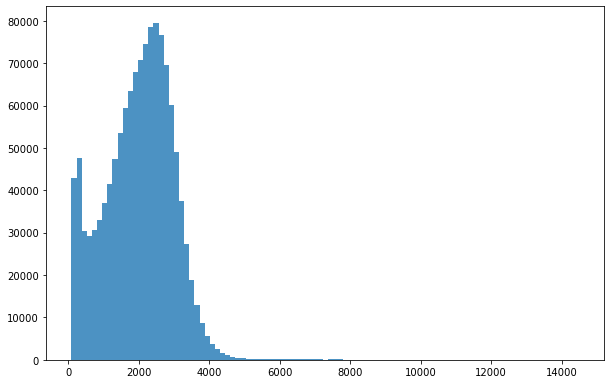

In [4]:
bins = np.linspace(min(predictors['h']),max(predictors['h']),100)
plt.hist((predictors['h']),bins,alpha=0.8);

Select only tree with height less then 70m (highest tree in germany 67m https://visit.freiburg.de/en/attractions/waldtraut-germany-s-tallest-tree)

In [5]:
predictors_sel = predictors.loc[(predictors['h'] < 7000)  ].sample(100000)
predictors_sel.insert ( 4, 'hm' ,  predictors_sel['h']/100 ) # add a culumn of heigh in meter
len(predictors_sel)
predictors_sel.head(10)

,ID,X,Y,h,hm,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
872178,872179,8.772581,49.714933,212.50,2.1250,1503,14,2866,6028,-3.931900,-213877408,2.512895,0.096170,516.147644,0,903.373047,533.976074,223.241211,-0.117382,13,723799,22.449127,475.613708,79
500857,500858,7.464461,49.623168,917.00,9.1700,1540,15,1899,6211,6.591823,-282356256,0.807505,-0.102080,389.780334,22,199.039062,298.529297,363.786621,-0.036253,11,619835,19.662125,463.219116,100
323332,323333,7.041806,48.448750,3224.75,32.2475,1360,16,3459,6054,19.351595,-127179080,0.869966,0.144863,539.989075,26,-27.761963,-23.405762,-89.702148,-0.307340,24,969414,22.950663,459.358398,85
141582,141583,6.561226,49.469128,2899.00,28.9900,1544,12,2245,6074,-56.291782,-236613616,1.922161,-0.035257,331.519592,23,665.146484,94.720703,158.346191,-0.061353,9,733138,19.429295,449.283020,85
857786,857787,8.732884,49.889220,2356.00,23.5600,1534,12,2361,6467,34.290249,-87513128,-1.106307,-0.016480,179.532364,27,197.832520,283.815674,360.765625,-0.003575,9,623369,18.716999,473.101593,78
748590,748591,8.401779,49.702189,3238.25,32.3825,1539,17,1924,6594,-11.810678,-97597936,-1.667313,0.003826,89.614937,21,378.935303,-92.358887,112.199219,-0.003051,5,624145,20.682150,524.337280,78
816221,816222,8.636404,49.738341,3526.25,35.2625,1502,14,2475,6371,10.890288,-23041260,-0.726972,-0.103524,231.248123,25,404.782227,261.536377,453.965820,0.047365,11,637962,18.618427,472.087921,87
1099405,1099406,9.339143,49.700987,205.50,2.0550,1495,15,2094,6619,4.807510,20254866,-1.877263,-0.126719,185.742264,3,765.513428,618.325928,578.000732,-0.133659,14,717809,20.441570,503.452728,27
1031869,1031870,9.167911,49.070142,197.50,1.9750,1513,16,2230,6689,23.209263,-21237448,-1.547910,-0.002255,170.389755,5,707.500488,420.511963,394.517334,-0.010262,7,783229,22.032221,550.120239,20
238279,238280,6.829212,49.605072,2299.25,22.9925,1374,20,2471,5637,-1.107219,-231400208,3.262866,-0.053148,652.094299,25,-73.620850,-115.895508,11.251831,0.180824,28,711901,21.820713,432.980743,96


Plotting response variables distribution

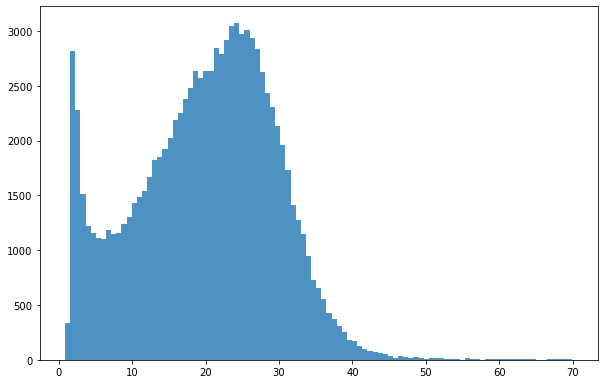

In [6]:
bins = np.linspace(min(predictors_sel['hm']),max(predictors_sel['hm']),100)
plt.hist((predictors_sel['hm']),bins,alpha=0.8);

The Global Forest Canopy Height, 2019 map has been release in 2020 (scientific publication https://doi.org/10.1016/j.rse.2020.112165). The authors use a regression tree model that was calibrated and applied to each individual Landsat GLAD ARD tile (1 × 1◦) in a “moving window” mode. Such tree height estimation is storede in forestheight.tiff and in the table as forestheight column. 
A correlation plot and its pearson coefficient is show below.

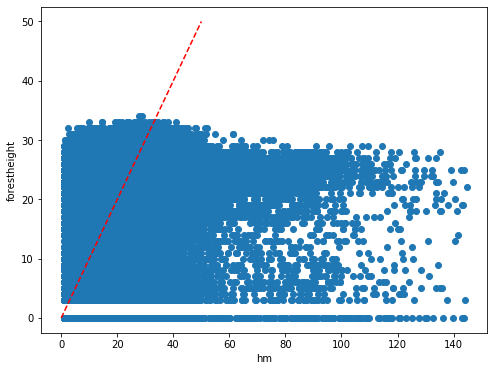

In [7]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(predictors['h']/100,predictors['forestheight'])
plt.xlabel('hm')
plt.ylabel('forestheight')
ident = [0, 50]
plt.plot(ident,ident,'r--')


In [8]:
pearsonr_Publication_Estimation = pearsonr(predictors['h'],predictors['forestheight'])[0]
pearsonr_Publication_Estimation

0.4527925129990053

We will try to beats such error estimation using a more advance ML tecnques and different enviromental predictors that better express the ecological condition.

## Data set splitting
Split the dataset (predictors_sel) in order to create response variable vs predictors variables (we are excluding forestheight predictors).

In [9]:
   X = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].values
Y = predictors_sel.iloc[:,4:5].values
feat = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].columns.values

Double ceck that we select the right columns

In [10]:
feat

array(['BLDFIE_WeigAver', 'CECSOL_WeigAver', 'CHELSA_bio18',
       'CHELSA_bio4', 'convergence', 'cti', 'devmagnitude', 'eastness',
       'elev', 'glad_ard_SVVI_max', 'glad_ard_SVVI_med',
       'glad_ard_SVVI_min', 'northness', 'ORCDRC_WeigAver',
       'outlet_dist_dw_basin', 'SBIO3_Isothermality_5_15cm',
       'SBIO4_Temperature_Seasonality_5_15cm', 'treecover'], dtype=object)

In [11]:
Y.shape

(100000, 1)

In [12]:
X.shape

(100000, 18)

Create 4 dataset for training and testing the algorithm 

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

## Random Forest default parameters

Random Forest can be implemented using the [RandomForestRegressor in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Training Random Forest using default parameters

In [14]:
rf = RandomForestRegressor(random_state = 42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [15]:
rfReg = RandomForestRegressor(min_samples_leaf=50, oob_score=True)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
pearsonr_all = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
pearsonr_all

[0.6045516697930429, 0.5165166299857089]

In [16]:
# checking the oob score
rfReg.oob_score_

0.2645722993587867

Additional resources how to reduce the oob error can found at  
https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

### Random Forest tuning


* "max_features": number of features to consider when looking for the best split. 
* "max_samples": number of samples to draw from X to train each base estimator.
* "n_estimators": identify the number of trees that must grow. It must be large enough so that the error is stabilized. Defoult 100.
* "max_depth": max number of levels in each decision tree.

Using this pseudo code tune the parameters in order the improve the algoirithm performance


    pipeline = Pipeline([('rf',RandomForestRegressor())])

    parameters = {
            'rf__max_features':(3,4,5),
            'rf__max_samples':(0.5,0.6,0.7),
            'rf__n_estimators':(500,1000),
            'rf__max_depth':(50,100,200,300)}

    grid_search = GridSearchCV(pipeline,parameters,n_jobs=6,cv=5,scoring='r2',verbose=1)
    grid_search.fit(X_train,y_train)
    

    rfReg = RandomForestRegressor(n_estimators=5000,max_features=0.33,max_depth=500,max_samples=0.7,n_jobs=-1,random_state=24 , oob_score = True) 
    rfReg.fit(X_train, y_train); 
    dic_pred = {} 
    dic_pred['train'] = rfReg.predict(X_train) 
    dic_pred['test'] = rfReg.predict(X_test) 
    pearsonr_all_tune = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]] 
    pearsonr_all_tune

    grid_search.best_score_

    print ('Best Training score: %0.3f' % grid_search.best_score_) 
    print ('Optimal parameters:') best_par = grid_search.best_estimator_.get_params() 
    for par_name in sorted(parameters.keys()): 
        print ('\t%s: %r' % (par_name, best_par[par_name]))
        
Tracking the error rate trend as in https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

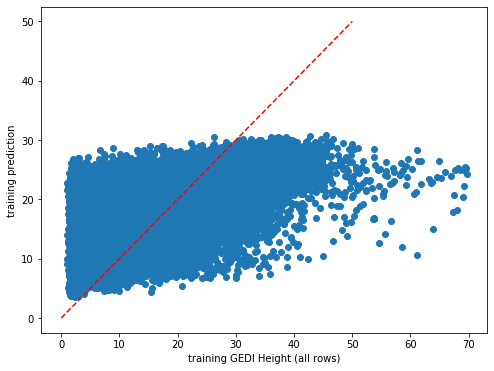

In [17]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('training GEDI Height (all rows)')
plt.ylabel('training prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

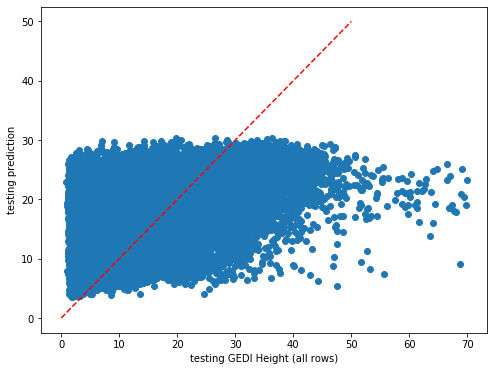

In [18]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('testing GEDI Height (all rows)')
plt.ylabel('testing prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [19]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [20]:
ind

array([ 1, 13,  0,  6,  8,  4, 16,  2,  5, 15, 12,  3, 11,  7, 14,  9, 10,
       17])

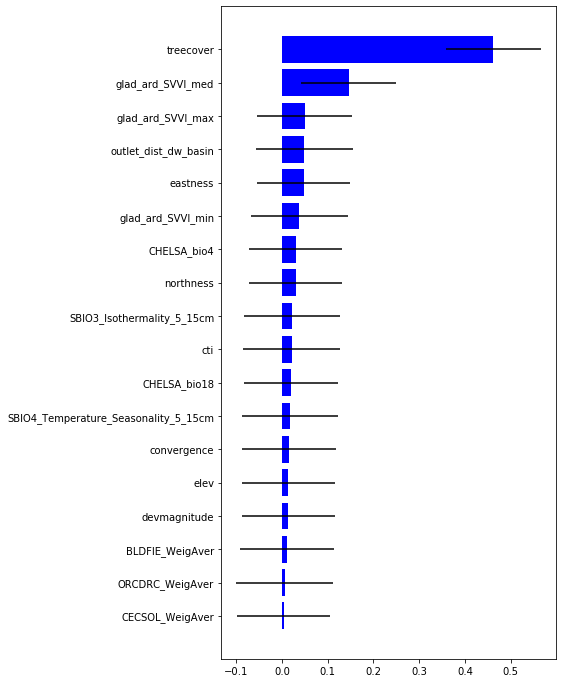

In [21]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

Most important variable is treecover followed by Spectral Variability Vegetation Index, followed by outlet_dist_dw_basin that is a proxy of water accumulation. Besides eastness and northness describes microclimat condition.

## Base on data quality flag select more reilable tree height.

**File storing tree hight (cm) obtained by 6 algorithms, with their associate quality flags.**
The quality flags can be used to refine and select the best tree height estimation and use it as tree height observation.

* a?_95: tree hight (cm) at 95 quintile, for each algorithm  
* min_rh_95: minimum value of tree hight (cm) ammong the 6 algorithms  
* max_rh_95: maximum value of tree hight (cm) ammong the 6 algorithms  
* BEAM: 1-4 coverage beam = lower power (worse) ; 5-8 power beam = higher power (better)  
* digital_elev: digital mdoel elevation  
* elev_low: elevation of center of lowest mode  
* qc_a?: quality_flag for six algorithms quality_flag = 1 (better); = 0 (worse)  
* se_a?: sensitivity for six algorithms sensitivity < 0.95 (worse);  sensitivity > 0.95  (beter )  
* deg_fg: (degrade_flag) not-degraded 0 (better) ;  degraded > 0 (worse)  
* solar_ele: solar elevation. > 0 day (worse); < 0 night (better)  

In [22]:
height_6algorithms = pd.read_csv("tree_height/txt/eu_y_x_select_6algorithms_fullTable.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
height_6algorithms.head(6)

,ID,X,Y,a1_95,a2_95,a3_95,a4_95,a5_95,a6_95,min_rh_95,max_rh_95,BEAM,digital_elev,elev_low,qc_a1,qc_a2,qc_a3,qc_a4,qc_a5,qc_a6,se_a1,se_a2,se_a3,se_a4,se_a5,se_a6,deg_fg,solar_ele
0,1,6.050001,49.727499,3139,3139,3139,3120,3139,3139,3120,3139,5,410.0,383.72153,1,1,1,1,1,1,0.962,0.984,0.968,0.962,0.989,0.979,0,17.7
1,2,6.050002,49.922155,1022,2303,970,872,5596,1524,872,5596,5,290.0,2374.14110,0,0,0,0,0,0,0.948,0.990,0.960,0.948,0.994,0.980,0,43.7
2,3,6.050002,48.602377,380,1336,332,362,1336,1340,332,1340,4,440.0,435.97781,1,1,1,1,1,1,0.947,0.975,0.956,0.947,0.981,0.968,0,0.2
3,4,6.050009,48.151979,3153,3142,3142,3127,3138,3142,3127,3153,2,450.0,422.00537,1,1,1,1,1,1,0.930,0.970,0.943,0.930,0.978,0.962,0,-14.2
4,5,6.050010,49.588410,666,4221,651,33,5611,2723,33,5611,8,370.0,2413.74830,0,0,0,0,0,0,0.941,0.983,0.946,0.941,0.992,0.969,0,22.1
5,6,6.050014,48.608456,787,1179,1187,761,1833,1833,761,1833,3,420.0,415.51581,1,1,1,1,1,1,0.952,0.979,0.961,0.952,0.986,0.975,0,0.2


In [23]:
height_6algorithms_sel = height_6algorithms.loc[(height_6algorithms['BEAM'] > 4) 
                                            &   (height_6algorithms['qc_a1'] == 1)
                                            &   (height_6algorithms['qc_a2'] == 1)
                                            &   (height_6algorithms['qc_a3'] == 1)    
                                            &   (height_6algorithms['qc_a4'] == 1)    
                                            &   (height_6algorithms['qc_a5'] == 1)    
                                            &   (height_6algorithms['qc_a6'] == 1)
                                            &   (height_6algorithms['se_a1'] > 0.95)    
                                            &   (height_6algorithms['se_a2'] > 0.95)
                                            &   (height_6algorithms['se_a3'] > 0.95)
                                            &   (height_6algorithms['se_a4'] > 0.95)
                                            &   (height_6algorithms['se_a5'] > 0.95)   
                                            &   (height_6algorithms['se_a6'] > 0.95)
                                            &   (height_6algorithms['deg_fg'] == 0)  
                                            &   (height_6algorithms['solar_ele'] < 0)]

In [24]:
height_6algorithms_sel

,ID,X,Y,a1_95,a2_95,a3_95,a4_95,a5_95,a6_95,min_rh_95,max_rh_95,BEAM,digital_elev,elev_low,qc_a1,qc_a2,qc_a3,qc_a4,qc_a5,qc_a6,se_a1,se_a2,se_a3,se_a4,se_a5,se_a6,deg_fg,solar_ele
7,8,6.050019,49.921613,3303,3288,3296,3236,3857,3292,3236,3857,7,320.0,297.68533,1,1,1,1,1,1,0.971,0.988,0.976,0.971,0.992,0.984,0,-33.9
11,12,6.050039,47.995344,2762,2736,2740,2747,3893,2736,2736,3893,5,390.0,368.55121,1,1,1,1,1,1,0.975,0.990,0.979,0.975,0.994,0.987,0,-37.3
14,15,6.050046,49.865317,1398,2505,2509,1316,2848,2505,1316,2848,6,340.0,330.40564,1,1,1,1,1,1,0.973,0.990,0.979,0.973,0.994,0.986,0,-18.2
15,16,6.050048,49.050020,984,943,947,958,2617,947,943,2617,6,300.0,291.22598,1,1,1,1,1,1,0.978,0.991,0.982,0.978,0.995,0.988,0,-35.4
16,17,6.050049,48.391359,3362,3332,3336,3351,4467,3336,3332,4467,5,530.0,504.78122,1,1,1,1,1,1,0.973,0.988,0.977,0.973,0.992,0.984,0,-5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267207,1267208,9.949829,49.216272,2160,2816,2816,2104,3299,2816,2104,3299,8,420.0,386.44556,1,1,1,1,1,1,0.980,0.993,0.984,0.980,0.995,0.989,0,-16.9
1267211,1267212,9.949856,49.881190,3190,3179,3179,3171,3822,3179,3171,3822,6,380.0,363.69348,1,1,1,1,1,1,0.968,0.986,0.974,0.968,0.990,0.982,0,-35.1
1267216,1267217,9.949880,49.873435,2061,2828,2046,2024,2828,2828,2024,2828,7,380.0,361.06812,1,1,1,1,1,1,0.967,0.988,0.974,0.967,0.993,0.983,0,-35.1
1267227,1267228,9.949958,49.127182,366,2307,1260,355,3531,2719,355,3531,6,500.0,493.52792,1,1,1,1,1,1,0.973,0.989,0.978,0.973,0.993,0.985,0,-36.0


Calculate the mean height excluidng the maximum and minimum values 

In [25]:
height_sel =  pd.DataFrame({'ID' : height_6algorithms_sel['ID'] , 
                            'hm_sel': (height_6algorithms_sel['a1_95'] + height_6algorithms_sel['a2_95'] + height_6algorithms_sel['a3_95'] + height_6algorithms_sel['a4_95'] 
                             + height_6algorithms_sel['a5_95'] + height_6algorithms_sel['a6_95'] - height_6algorithms_sel['min_rh_95'] - height_6algorithms_sel['max_rh_95']) / 400 } )

In [26]:
height_sel

,ID,hm_sel
7,8,32.9475
11,12,27.4625
14,15,22.2925
15,16,9.5900
16,17,33.4625
...,...,...
1267207,1267208,26.5200
1267211,1267212,31.8175
1267216,1267217,24.4075
1267227,1267228,16.6300


Merge the new height with the predictors table, using the ID as Primary Key

In [27]:
predictors_hm_sel = pd.merge( predictors ,  height_sel , left_on='ID' ,  right_on='ID' ,  how='right')

In [28]:
predictors_hm_sel.head(6)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover,hm_sel
0,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86,32.9475
1,12,6.050039,47.995344,2746.25,1523,12,2612,6181,3.549103,-71279992,0.507727,-0.021408,322.920227,26,660.006104,92.722168,190.979736,-0.034787,16,784807,20.798000,460.501221,97,27.4625
2,15,6.050046,49.865317,2229.25,1517,13,2191,5901,31.054762,-186807440,-1.375050,-0.126880,291.412537,7,1028.385498,915.806396,841.586182,0.024677,16,766444,19.941267,454.185089,54,22.2925
3,16,6.050048,49.050020,959.00,1526,14,2081,6100,9.933455,-183562672,-0.382834,0.086874,246.288010,24,-12.283691,-58.179199,174.205566,0.094175,10,805730,19.849365,470.946533,78,9.5900
4,17,6.050049,48.391359,3346.25,1489,19,2486,5966,-6.957157,-273522688,2.989759,0.214769,474.409088,24,125.583008,6.154297,128.129150,0.017164,15,950190,21.179420,491.398376,85,33.4625
5,19,6.050053,49.877876,529.00,1531,12,2184,5915,-24.278454,-377335296,0.265329,-0.248356,335.534760,25,593.601074,228.712402,315.298340,-0.127365,17,764713,19.760756,448.580811,96,5.2900


In [29]:
predictors_hm_sel = predictors_hm_sel.loc[(predictors['h'] < 7000) ].sample(100000)

In [30]:
predictors_hm_sel

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover,hm_sel
143789,815169,8.632821,49.034831,3044.25,1518,17,2335,6493,3.804472,59137836,-1.245918,0.009648,199.027420,26,449.903320,30.683350,98.910889,0.022706,6,724983,18.189413,472.922943,85,30.4425
44159,242052,6.839339,48.227700,2073.00,1376,22,3196,6137,-60.841110,-314753952,1.452752,0.041967,623.728943,25,-37.671143,15.598389,-129.838623,-0.118565,35,960418,21.139074,441.945343,85,20.7300
104121,578712,7.688297,49.853221,2746.00,1530,13,1928,6140,-34.775543,-195900432,1.506492,-0.029628,411.755463,26,456.291504,-77.499512,190.601807,-0.030758,15,572910,17.918188,451.509552,97,27.4600
121530,689773,8.026682,49.412415,2263.50,1468,11,1898,6305,33.684132,-154102208,-0.757823,-0.120561,283.114105,26,-32.457275,-169.748535,-326.925049,0.201635,18,721018,18.552692,464.347565,85,22.6350
63153,338027,7.074375,49.232423,1900.50,1480,13,2053,6239,47.012951,-34345416,-1.655371,-0.091201,237.077621,20,40.280762,191.425537,-3.062012,0.130362,13,794537,20.181999,484.392090,79,19.0050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85959,463220,7.364289,49.006977,3450.50,1494,12,2352,6193,2.693601,-49939724,-1.639730,-0.089378,313.716644,26,363.479492,-116.296387,95.510010,-0.059095,11,886926,18.380312,460.264801,99,34.5050
222400,1242022,9.826905,49.181223,3382.50,1510,19,2349,6637,32.044640,-125240416,-2.068509,-0.184956,338.459137,24,281.717529,179.264893,264.452637,0.017225,14,836909,19.674150,505.846466,85,33.8250
23418,124266,6.497753,49.806452,2038.75,1524,14,1954,6178,0.290976,-245096976,-1.431028,0.158236,217.341431,12,-82.375977,-4.113770,249.067627,0.006056,11,711148,21.360710,482.407990,78,20.3875
156064,888098,8.808580,49.732382,4020.75,1482,14,2699,6202,-4.201675,-254775360,1.657472,0.202774,423.492188,26,135.752930,245.324951,135.681396,-0.070500,12,718918,20.607891,479.666687,85,40.2075


In [31]:
   X = predictors_hm_sel.iloc[:,[4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22]].values
Y = predictors_hm_sel.iloc[:,23:24].values
feat = predictors_hm_sel.iloc[:,[4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22]].columns.values

In [32]:
feat

array(['BLDFIE_WeigAver', 'CECSOL_WeigAver', 'CHELSA_bio18',
       'CHELSA_bio4', 'convergence', 'cti', 'devmagnitude', 'eastness',
       'elev', 'glad_ard_SVVI_max', 'glad_ard_SVVI_med',
       'glad_ard_SVVI_min', 'northness', 'ORCDRC_WeigAver',
       'outlet_dist_dw_basin', 'SBIO3_Isothermality_5_15cm',
       'SBIO4_Temperature_Seasonality_5_15cm', 'treecover'], dtype=object)

In [33]:
Y.shape

(100000, 1)

In [34]:
X.shape

(100000, 18)

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

## Random Forest default parameters with select row base on quality flag
Training Random Forest using default parameters

In [36]:
rfReg = RandomForestRegressor(min_samples_leaf=20, oob_score=True)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)

In [37]:
# checking the oob score
rfReg.oob_score_

0.36202198818906683

## Final assesment

**Selected data**

In [38]:
pearsonr_all_sel = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
pearsonr_all_sel

[0.7405031288359375, 0.616599717521936]

**All data**

In [39]:
pearsonr_all

[0.6045516697930429, 0.5165166299857089]

**Publication results** 

In [40]:
pearsonr_Publication_Estimation

0.4527925129990053

Tone the RF

    pipeline = Pipeline([('rf',RandomForestRegressor())])

    parameters = {
            'rf__max_features':("log2","sqrt",0.33),
            'rf__max_samples':(0.5,0.6,0.7),
            'rf__n_estimators':(500,1000),
            'rf__max_depth':(50,100,200)}

    grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=3,scoring='r2',verbose=1)
    grid_search.fit(X_train,y_train)

    grid_search.best_score_

    print ('Best Training score: %0.3f' % grid_search.best_score_)
    print ('Optimal parameters:')
    best_par = grid_search.best_estimator_.get_params()
    for par_name in sorted(parameters.keys()):
        print ('\t%s: %r' % (par_name, best_par[par_name]))


    rfReg = RandomForestRegressor(n_estimators=500,max_features='sqrt',max_depth=50,max_samples=0.6,n_jobs=-1,random_state=24)
    rfReg.fit(X_train, y_train);
    dic_pred = {}
    dic_pred['train'] = rfReg.predict(X_train)
    dic_pred['test'] = rfReg.predict(X_test)
    [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]

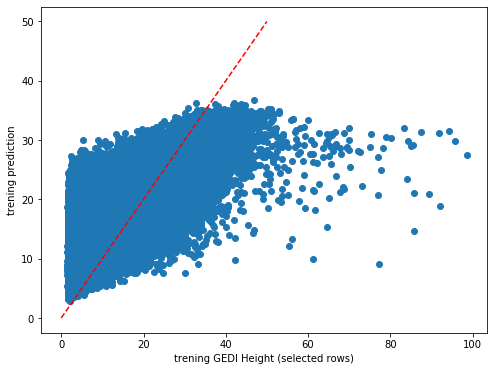

In [41]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('trening GEDI Height (selected rows)')
plt.ylabel('trening prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

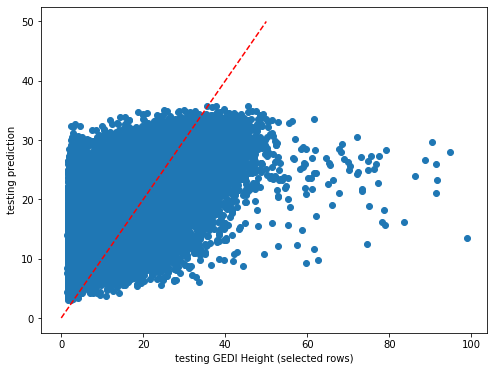

In [42]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('testing GEDI Height (selected rows)')
plt.ylabel('testing prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [43]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [44]:
ind

array([ 1, 13,  0, 16,  6,  4,  5,  8,  2,  3, 15, 11, 12,  9, 14,  7, 10,
       17])

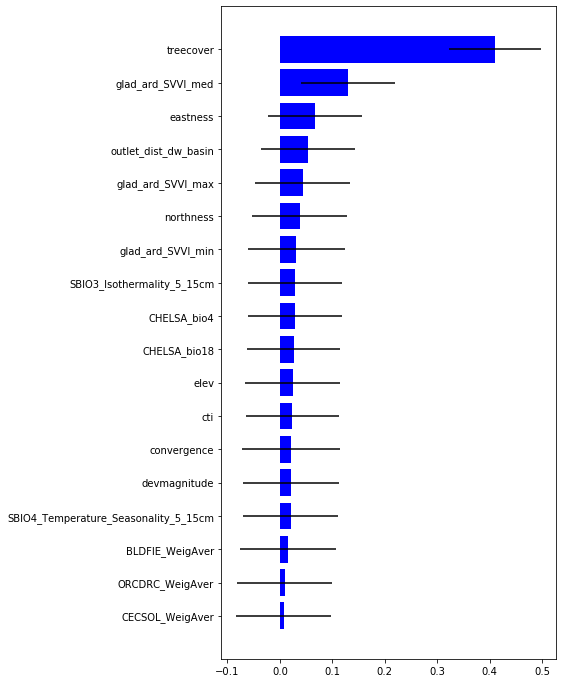

In [45]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

### Predict on the raster using pyspatialml

In [46]:
# import satalite indeces
glad_ard_SVVI_min = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_min.tif")
glad_ard_SVVI_med = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_med.tif")
glad_ard_SVVI_max = rasterio.open("tree_height/geodata_raster/glad_ard_SVVI_max.tif")

# import climate
CHELSA_bio4 = rasterio.open("tree_height/geodata_raster/CHELSA_bio4.tif")
CHELSA_bio18 = rasterio.open("tree_height/geodata_raster/CHELSA_bio18.tif")

# soil
BLDFIE_WeigAver = rasterio.open("tree_height/geodata_raster/BLDFIE_WeigAver.tif")
CECSOL_WeigAver = rasterio.open("tree_height/geodata_raster/CECSOL_WeigAver.tif")
ORCDRC_WeigAver = rasterio.open("tree_height/geodata_raster/ORCDRC_WeigAver.tif")

# Geomorphological
elev = rasterio.open("tree_height/geodata_raster/elev.tif")
convergence = rasterio.open("tree_height/geodata_raster/convergence.tif")
northness = rasterio.open("tree_height/geodata_raster/northness.tif")
eastness = rasterio.open("tree_height/geodata_raster/eastness.tif")
devmagnitude = rasterio.open("tree_height/geodata_raster/dev-magnitude.tif")

# Hydrography
cti = rasterio.open("tree_height/geodata_raster/cti.tif")
outlet_dist_dw_basin = rasterio.open("tree_height/geodata_raster/outlet_dist_dw_basin.tif")

# Soil climate

SBIO3_Isothermality_5_15cm = rasterio.open("tree_height/geodata_raster/SBIO3_Isothermality_5_15cm.tif")
SBIO4_Temperature_Seasonality_5_15cm = rasterio.open("tree_height/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif")

# forest

treecover = rasterio.open("tree_height/geodata_raster/treecover.tif")


In [47]:
predictors_rasters = [glad_ard_SVVI_min, glad_ard_SVVI_med, glad_ard_SVVI_max,
                      CHELSA_bio4,CHELSA_bio18,
                      BLDFIE_WeigAver,CECSOL_WeigAver, ORCDRC_WeigAver,
                      elev,convergence,northness,eastness,devmagnitude,cti,outlet_dist_dw_basin,
                      SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover]

stack = Raster(predictors_rasters)

In [48]:
result = stack.predict(estimator=rfReg, dtype='int16', nodata=-1)

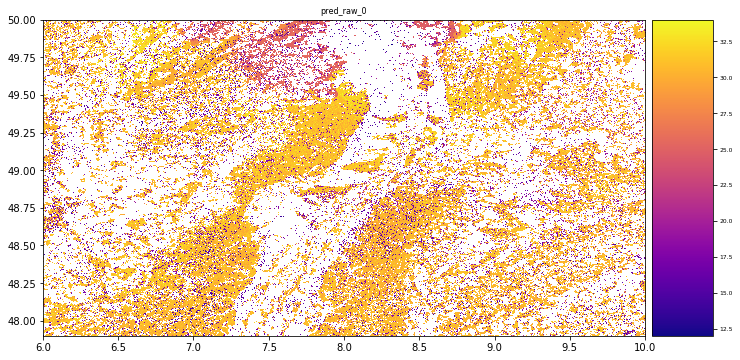

In [49]:
# plot regression result
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()